## Example - 3 day full body program

This notebook shows features of [streprogen](https://github.com/tommyod/streprogen), the Python strength program generator.

- [GitHub repository](https://github.com/tommyod/streprogen)
- [Python Package Index (PyPI)](https://pypi.org/project/streprogen/)
- [Report issues or make feature requests](https://github.com/tommyod/streprogen/issues)

Contributions to the code are welcome. :)

In [1]:
!pip install streprogen matplotlib --quiet --no-cache --upgrade

In [2]:
import functools
import matplotlib.pyplot as plt

In [3]:
from streprogen import Program
from streprogen.utils import round_to_nearest
from streprogen.modeling import (reps_to_intensity_tight, 
                                 progression_diffeq,
                                 progression_sawtooth)

In [4]:
duration = 16
percent_inc_per_week = 1
period = 4

## Create a custom sawtooth progress function with deloads

In [5]:
def progression_sawtooth_clipped(week, start_weight,
    final_weight, start_week, final_week, **kwargs):
    """Clipped progress function with deloading."""
    
    # Standard sawtooth progression function from streprogen
    ans = progression_sawtooth(week,
    start_weight,
    final_weight,
    start_week,
    final_week, **kwargs)
    
    # Every `period` weeks, add a deloading week
    if (week - 1) % period == 0:
        ans = ans * 0.97 # Deload factor
    
    # Clip the results and and return
    return max(start_weight * 0.99, min(ans, final_weight * 1.01))

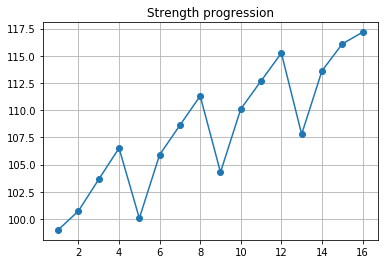

In [6]:
# Parameters for the plot
weeks = list(range(1, duration+1))
start_weight = 100
final_weight = round(100 * (1 + duration * (percent_inc_per_week / 100)))

# Evaluate the function 
params = {"period":period, "scale":0.022, "offset":0, "k":1.1}
y = [progression_sawtooth_clipped(
    w,
    start_weight=start_weight,
    final_weight=final_weight,
    start_week=1,
    final_week=duration,
    **params
) for w in weeks]

# Plot the general strength progression function
plt.title("Strength progression")
plt.plot(weeks, y, '-o')
plt.grid(True)
plt.show()

In [7]:
progress = functools.partial(progression_sawtooth_clipped, **params)

### Set up scaling functions for intensity and repetitions

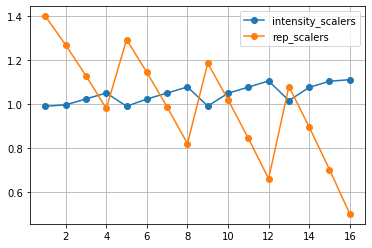

In [8]:
params = {"start_weight":1.0, 
          "final_weight":1.1,
          "start_week":1, 
          "final_week":duration,
          "period":period, 
          "scale":0.03}
intensity_scalers = [progression_sawtooth_clipped(w, **params) for w in weeks]
intensity_scaler_func = functools.partial(progression_sawtooth_clipped, **params)


params = {"start_weight":1 - 0.25, 
          "final_weight":1 + 0.25,
          "start_week":1, 
          "final_week":duration,
          "period":period, 
          "scale":0.2}


def inv_sawtooth(*args, **kwargs):
    return 2 - progression_sawtooth(*args, **kwargs)

rep_scalers = [inv_sawtooth(w, **params) for w in weeks]
rep_scaler_func = functools.partial(inv_sawtooth, **params)

# Create a plot
plt.plot(weeks, intensity_scalers, '-o', label="intensity_scalers")
plt.plot(weeks, rep_scalers, '-o', label="rep_scalers")
plt.legend()
plt.grid(True)
plt.show()

### Program setup

Below is the code creating the program.

In [9]:
program = Program(name=f'3days{duration}weeks', 
                duration=duration, 
                percent_inc_per_week=percent_inc_per_week,
                reps_per_exercise=22, 
                rep_scaler_func=rep_scaler_func, 
                intensity=reps_to_intensity_tight(6), 
                intensity_scaler_func=intensity_scaler_func, 
                progression_func=progress, 
                # Using the 'tight' function instead of the standard one
                reps_to_intensity_func=reps_to_intensity_tight, 
                units='', 
                round_to=2.5,
                verbose=True)


def lunges(w):
    weight = 24 + ((w - 1) // 2) * 2
    sets = 3 if (w % 2) else 4
    weight = round_to_nearest(weight, 2)
    return f"{sets} x 6 @ {weight} kg"

def military(w):
    weight = 55 + ((w - 1) // 2) * 2.5
    sets = 3 if (w % 2) else 4
    weight = round_to_nearest(weight, 2.5)
    return f"{sets} x 6 @ {weight} kg"

def deadlifts(w):
    weight = progression_diffeq(
    week=w,
    start_weight=80,
    final_weight=150,
    start_week=1,
    final_week=duration,
    k=2,
)
    weight = round_to_nearest(weight, 2.5)
    return f"3 x 3 @ {weight} kg"


with program.Day("Day 1"):
    program.DynamicExercise("Bench press", start_weight=140, min_reps=2, max_reps=7)
    program.StaticExercise('Lunges', lunges)
    program.StaticExercise('Deadlifts', deadlifts)
    
with program.Day("Day 2"):
    program.DynamicExercise(name="Narrow-grip bench", start_weight=130, min_reps=2, max_reps=7)
    # My bodyweight is 85 kilograms, so I use (85 + 60) as the start weight for
    # chin ups. This means that my 1RM is 60kg in the belt.
    program.DynamicExercise(name="Chins 85kg+ (heavy)", start_weight=(85 + 60), 
                            min_reps=2, max_reps=7, round_to=5)
    program.StaticExercise('Dumbbell rows', "4 x 10 @ 40kg")
    
with program.Day("Day 3"):
    program.DynamicExercise(name="Chins 85kg+ (light)", start_weight=(85 + 45), 
                            min_reps=2, max_reps=7, round_to=5)
    program.DynamicExercise(name="Front squats", start_weight=120, final_weight=150, min_reps=3, max_reps=7)
    program.StaticExercise("Military press", military)

In [10]:
program.days[0].dynamic_exercises[0].final_weight

### Render the program

In [11]:
import warnings
warnings.filterwarnings("ignore")

# Do the computations and render a program. Might take a few seconds.
program.render()

Rendered program in 0.068 seconds.


In [12]:
print(program)

----------------------------------------------------------------
Program: 3days16weeks

Program parameters
  duration: 16
  reps_per_exercise: 22
  intensity: 81.25
  units: 
----------------------------------------------------------------
Exercise information
  Day 1
   Bench press           140 -> 162.4
    reps: [2, 7]   weekly inc.: 1.0%
   Lunges                3 x 6 @ 24 kg
   Deadlifts             3 x 3 @ 80 kg
  Day 2
   Narrow-grip bench     130 -> 150.8
    reps: [2, 7]   weekly inc.: 1.0%
   Chins 85kg+ (heavy)   145 -> 168.2
    reps: [2, 7]   weekly inc.: 1.0%
   Dumbbell rows         4 x 10 @ 40kg
  Day 3
   Chins 85kg+ (light)   130 -> 150.8
    reps: [2, 7]   weekly inc.: 1.0%
   Front squats          120 -> 150  
    reps: [3, 7]   weekly inc.: 1.6%
   Military press        3 x 6 @ 55 kg
----------------------------------------------------------------
Program
 Week 1
  Day 1
   Bench press           7 x 107.5  7 x 107.5  6 x 112.5  6 x 112.5  5 x 117.5  
   Lunges     

### Export the program as `.html` or `.tex`, then to `.pdf`

A `.html` file can be printed directly from your browser, or printed to a `.pdf` from your browser.

In [13]:
# Save the program as a HTML file
with open(f'{program.name}.html', 'w', encoding='utf-8') as file:
    # Control table width (number of sets) by passing the 'table_width' argument
    file.write(program.to_html(table_width=8))

In [14]:
# Save the program as a TEX file
with open(f'{program.name}.tex', 'w', encoding='utf-8') as file:
    file.write(program.to_tex(table_width=8))

Use a `.tex` to generate `.pdf` if you have LaTeX installed, or use:
    
- [latexbase.com](https://latexbase.com/) from your browser.

In [15]:
# If you have LaTeX installed on your system, you can render a program to .tex
# Alternatively, you can paste the LaTeX into: https://latexbase.com/
print(program.to_tex(table_width=8))

% -----------------------------------------------
% Package imports
% -----------------------------------------------
\documentclass[12pt, a4paper]{article}% 'twoside' for printing
\usepackage[utf8]{inputenc}% Allow input to be UTF-8
\usepackage[margin = 2cm]{geometry}% May be used to set margins

% -----------------------------------------------
% Document start
% -----------------------------------------------

\begin{document}
\large

\section*{Program: 3days16weeks}

This program was made using \verb|streprogen|,
the Python strength program generator.
The latest version can be found at \\
\verb|https://pypi.python.org/pypi/streprogen/|.


\section*{Program parameters}
\begin{tabular}{l|l}
	\textbf{Parameter} & \textbf{Value} \\ \hline
	\verb|duration|             & 16 \\
	\verb|reps_per_exercise|    & 22 \\
	\verb|intensity|            & 81.25 \\
	\verb|units|                & 
\end{tabular}


\section*{Exercise information}
\begin{tabular}{llllll}
    \textbf{Exercise} & \textbf{S